In [2]:
# import libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.metrics import accuracy_score
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
insurance = pd.read_csv('insurance.csv')

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
Number of Features  :  7
Number of Observations  :  1338



age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object



object     3
int64      2
float64    2
dtype: int64



age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64



               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.0

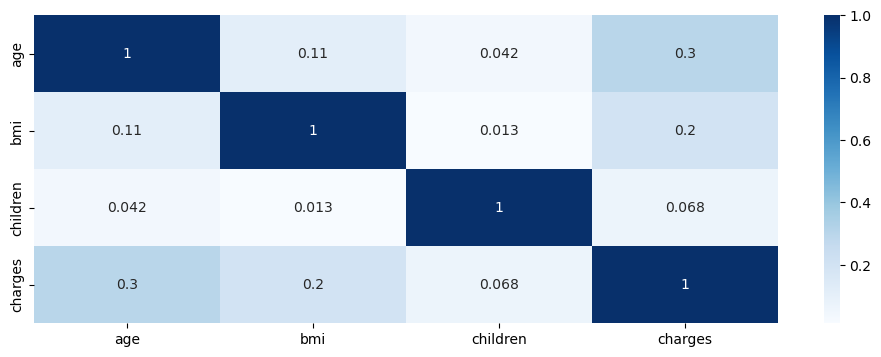

In [4]:
print(insurance.head(5))

print("Number of Features  : ", insurance.shape[1])
print("Number of Observations  : ", insurance.shape[0])
print("\n\n")

print(insurance.dtypes)
print("\n\n")
print(insurance.dtypes.value_counts())
print("\n\n")
"""
7 features in total are numerical while 5 are categorical. 
However, two of the numerical features, FastingBS and HeartDisease are categorical as well.

"""

print(insurance.isna().sum())
print("\n\n")
# Average Age of patients
print(insurance.describe())

correlations = insurance.corr()

plt.figure(figsize=(12,4))
sns.heatmap(correlations,annot=True, cmap='Blues')
plt.show()

Columns

 - age: age of primary beneficiary

 - sex: insurance contractor gender, female, male

 - bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

 - children: Number of children covered by health insurance / Number of dependents

 - smoker: Smoking

 - region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

 - charges: Individual medical costs billed by health insurance

array([[<AxesSubplot:title={'center':'charges'}>]], dtype=object)

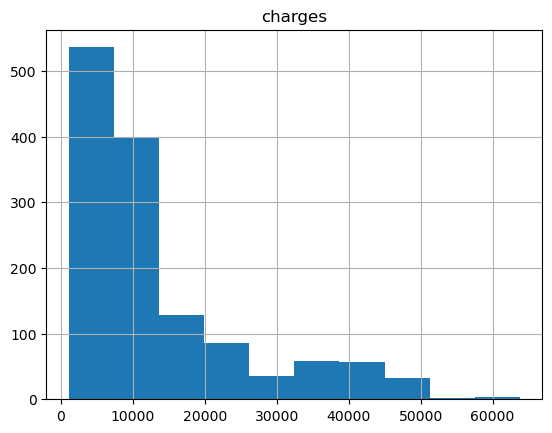

In [5]:
insurance.hist("charges")

The charges column is highly skewed to the right. 
Extremely costly insurance charges are more common than extremely small ones. 
This makes it unlikely that the errors in the model will truly be centered at zero. 
It might be worth it to log-transform the outcome.


array([[<AxesSubplot:title={'center':'log_charges'}>]], dtype=object)

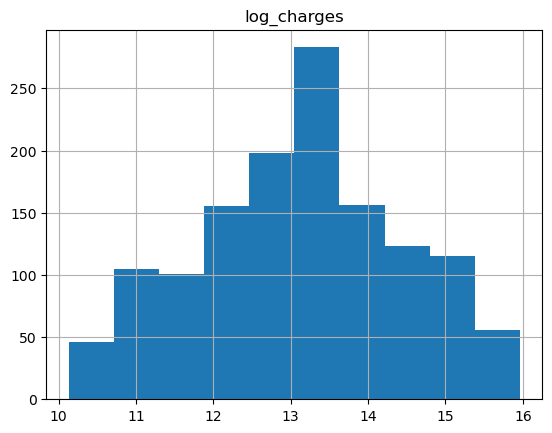

In [6]:
insurance['log_charges'] = np.log2(insurance['charges'])
insurance.hist("log_charges")

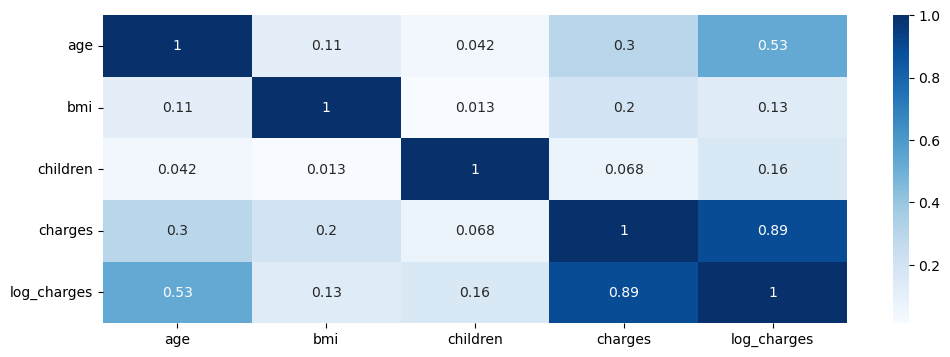

In [7]:
correlations = insurance.corr()

plt.figure(figsize=(12,4))
sns.heatmap(correlations,annot=True, cmap='Blues')
plt.show()

<AxesSubplot:title={'center':'log_charges'}, xlabel='region'>

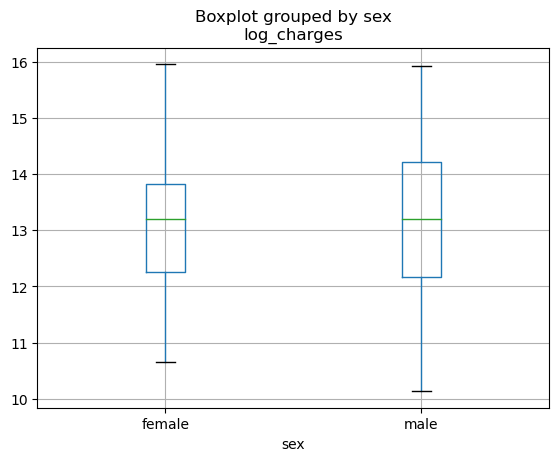

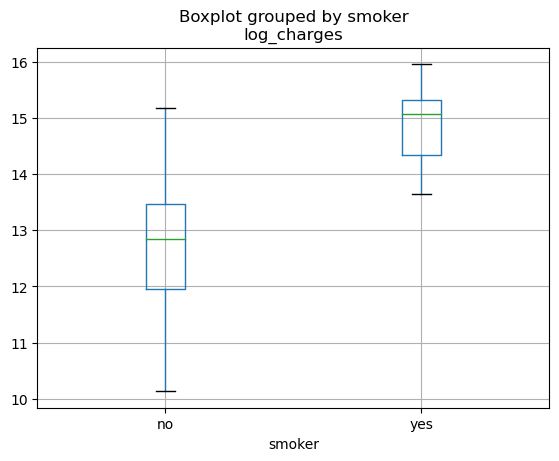

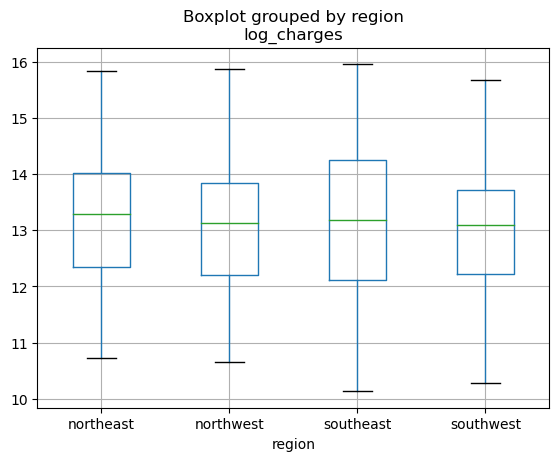

In [8]:
insurance.boxplot(column = ["log_charges"], by = "sex")
insurance.boxplot(column = ["log_charges"], by = "smoker")
insurance.boxplot(column = ["log_charges"], by = "region")


Males seem to have a wider distribution of charges compared to women.
Smokers have much higher costs than non-smokers.
There doesn't seem tobe many appreciable differences between regions.



Based on the univariate relationships shown above, age, bmi and smoker are positively associated with 
higher charges. We'll include these predictors in our final model.



In [26]:
insurance["is_smoker"] = (insurance["smoker"] == "yes")
X = insurance[['age','bmi','is_smoker']].copy()
y = insurance['log_charges'].copy()

#75 % TRaining and Testing Split.
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)


# Build The Model

In [27]:
model = LinearRegression()
model.fit(X_train,y_train)


LinearRegression()

In [28]:
# Get the predicts
y_predicts = model.predict(X_train)

# MSE on the log scale for the insurance charges
mean_squared_error(y_train, y_predicts)



0.4546665339270644

In [29]:
# MSE on the original scale for the insurance charges
np.exp(mean_squared_error(y_train, y_predicts))

1.575647870310887

In [30]:
# Coefficient of determination
r2_score(y_train, y_predicts)


0.7421118855283421

The training MSE for the model is 0.454 and is 1.57 on the original scale. 
The R2 indicates that the model can explain 74% of the variation in the log-insurance charges. 
These preliminary results are promising, but we must remember that these are optimistic values.

<AxesSubplot:xlabel='fitted', ylabel='residuals'>

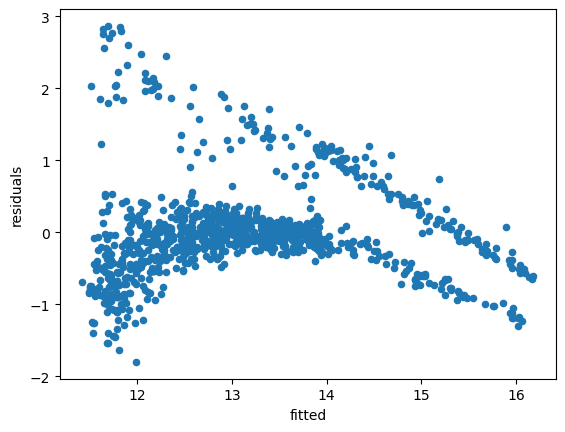

In [33]:
# Quick visual check of residuals
check = pd.DataFrame()
check["residuals"] = y_train - y_predicts
check["fitted"] = y_predicts

check.plot.scatter(x = "fitted", y = "residuals")

# Interpreting The Model


In [34]:
model.coef_

array([0.04892865, 0.01523672, 2.23063344])

 - A year increase in the subject is associated with a 0.04 increase in the log charges, holding smoking status and bmi constant. About a 4% increase in the charges on the regular scale.
 - A unit increase in the subject BMI is associated with a 0.01 increase in the log charges, holding smoking status and age constant. About a 1.5% increase in the charges on the regular scale.
 - A smoker is associated with a 2.23 increase in the log charges, holding age and bmi constant. About a 930% increase in the charges on the regular scale.
 
Note: we are not concerned about if these changes are statistically significant, so we don't know if these associations are truly non-zero. Our primary goal is prediction.

# Final Model Evaluation

In [40]:
test_predicts = model.predict(X_test)

mean_squared_error(y_test,test_predicts)

0.4355350875308211

In [41]:
np.exp(mean_squared_error(y_test,test_predicts))

1.545789970635098

# Drawing Conclusions
The test MSE was about 0.435, while the training MSE was about 0.454. 
In this case, the two errors match up pretty well, so we can conclude that the model is not overfit. 
The residuals suggest that the model is predicting much lower costs for subjects who were actually charged 
much higher. Therefore the model struggles with these higher costs. 

As a whole, the model predictions are too conservative.